In [3]:
## 1. DataSet import
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from prepare_datasets import *
from Helper_functions import *

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

X, y, feature_names, categorical_features, continuous_features, actionable_features = get_and_preprocess_cc()

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_pos = X[y == 1]
X_neg = X[y == 0]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [4]:
from Model import NeuralNetwork

model = NeuralNetwork(X.shape[1], 200, 2)
model1= NeuralNetwork(X.shape[1], 200, 2)
model2= NeuralNetwork(X.shape[1], 200, 2)
model3= NeuralNetwork(X.shape[1], 200, 2)
model4= NeuralNetwork(X.shape[1], 200, 2)
model5= NeuralNetwork(X.shape[1], 200, 2)
model6= NeuralNetwork(X.shape[1], 200, 2)

In [5]:
models = [model,model1, model2, model3, model4, model5, model6]
lambdas = [0,0.05,0.1,0.15,0.2,0.25,0.3]

model_path = f"models/Model_0_CC.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # Set to evaluation mode

# Load saved weights
for lambda_model, lamda in zip(models[1:], lambdas[1:]):
    model_path = f"models/model_lambda_{lamda:.2f}_CC.pth"
    lambda_model.load_state_dict(torch.load(model_path))
    lambda_model.eval()  # Set to evaluation mode


In [6]:
import torch.nn.functional as F
class WrappedModelForAlibi:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Important for consistent behavior

    def predict(self, x):
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32)
            logits = self.model(x_tensor)

            if logits.ndim == 1:
                logits = logits.unsqueeze(0)  # Ensure shape is (1, num_classes)

            probs = F.softmax(logits, dim=1)
            return probs.numpy()


In [15]:
from alibi.explainers import CEM
X_np = X.numpy()

# Wrap your model
predict_fn = WrappedModelForAlibi(model).predict

# Feature ranges from training data
feature_min = X_np.min(axis=0)
feature_max = X_np.max(axis=0)
feature_range = (feature_min, feature_max)

cem = CEM(
    predict_fn,
    mode='PN',
    shape=(1, X_np.shape[1]),
    max_iterations=1000,
    feature_range = feature_range
)
# Fit on a sample of training data (preferably more than 1)
cem.fit(X_np)

# Explain a sample (batch size 1)
explanation = cem.explain(X_np[1:2])

print(explanation)


No PN found!


Explanation(meta={
  'name': 'CEM',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'mode': 'PN',
              'shape': (1, 100),
              'kappa': 0.0,
              'beta': 0.1,
              'feature_range': (array([1.0005e+04, 1.6000e+00, 0.0000e+00, 2.6800e+00, 3.0000e-02,
       1.2000e-01, 4.5800e+00, 9.3800e+00, 4.6400e+00, 1.6600e+00,
       0.0000e+00, 0.0000e+00, 1.1576e+04, 3.1680e+01, 0.0000e+00,
       7.9100e+00, 4.8100e+00, 5.0000e-01, 3.4600e+00, 1.3785e+04,
       5.2370e+03, 5.4720e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 7.8000e+01, 6.4000e-01, 2.0000e-01, 2.0900e+00,
       1.6300e+00, 1.3200e+00, 2.4820e+01, 2.0500e+00, 8.6900e+00,
       1.3700e+00, 6.4800e+00, 2.1300e+00, 1.2060e+01, 3.3500e+00,
       2.8300e+00, 2.2900e+00, 3.2240e+01, 2.6110e+01, 2.7430e+01,
       3.0640e+01, 2.4420e+01, 4.1950e+01, 0.0000e+00, 0.0000e+00,
       2.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0

In [8]:
import torch

# Original instance and counterfactual from Alibi
original = torch.tensor(explanation.data['X'][0], dtype=torch.float32)
cf = torch.tensor(explanation.data['PN'][0], dtype=torch.float32)

# L1 distance
distance = torch.norm(original - cf, p=1)

print("L1 Distance between original and PN:", distance.item())

TypeError: 'NoneType' object is not subscriptable

In [10]:
from tqdm import tqdm

X_false_negatives, X_true_negatives, _, _  = split_by_classification(model,X_neg)

l1_distances = []
l2_distances = []

# Loop over each instance
for i in tqdm(range(len(X_true_negatives)), desc="Generating CEM counterfactuals"):
    x = X_true_negatives[i:i+1]  # keep shape (1, n_features)
    explanation = cem.explain(x)

    # Extract original and PN (pertinent negative) instance
    original = explanation.data['X'][0]
    pn = explanation.data['PN']

    if pn is not None:
        cf = pn[0]
        l1_distance = torch.norm(original - cf, p=1).item()
        l2_distance = torch.norm(original - cf, p=2).item()
        l1_distances.append(l1_distance)
        l2_distances.append(l2_distance)

l1_distances = np.array(l1_distances)
l2_distances = np.array(l2_distances)
# Print stats
print("Mean L1 Distance:", np.mean(l1_distances))
print("Mean L2 Distance:", np.mean(l2_distances))

Generating CEM counterfactuals:   0%|          | 0/809 [00:00<?, ?it/s]C:\Users\hamma\AppData\Local\Temp\ipykernel_18268\218918381.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
No PN found!
Generating CEM counterfactuals:   4%|▍         | 36/809 [03:55<1:24:21,  6.55s/it]


KeyboardInterrupt: 

In [12]:
# fist we calculate this subset
_, commun_negatives, _, _ = split_by_classification(model, X_neg)

for current_model in models:
    _, commun_negatives, _, _ = split_by_classification(current_model, commun_negatives)

print(len(commun_negatives))

806


In [13]:
cost_of_recourses_l1 = []
cost_of_recourses_l2 = []

for (best_model, lamda ) in zip(models,lambdas):
    print(f"Evaluating using CEM with lambda = {lamda}")
    X_np = X.numpy()

    predict_fn = WrappedModelForAlibi(best_model).predict
    # Feature ranges from training data
    feature_min = X_np.min(axis=0)
    feature_max = X_np.max(axis=0)
    feature_range = (feature_min, feature_max)

    cem = CEM(
        predict_fn,
        mode='PN',
        shape=(1, X_np.shape[1]),
        max_iterations=1000,
        feature_range = feature_range
    )
    # Fit on a sample of training data (preferably more than 1)
    cem.fit(X_np)


    l1_distances = []
    l2_distances = []

    # Loop over each instance
    for i in tqdm(range(len(commun_negatives)), desc="Generating CEM counterfactuals"):
        x = commun_negatives[i:i+1]  # keep shape (1, n_features)
        explanation = cem.explain(x)

        # Extract original and PN (pertinent negative) instance
        original = explanation.data['X'][0]
        pn = explanation.data['PN']

        if pn is not None:
            cf = pn[0]
            l1_distance = torch.norm(original - cf, p=1).item()
            l2_distance = torch.norm(original - cf, p=2).item()
            l1_distances.append(l1_distance)
            l2_distances.append(l2_distance)

    l1_distances = np.array(l1_distances)
    l2_distances = np.array(l2_distances)

    # Compute mean L1 distance
    cost_of_recourses_l1.append(l1_distances)
    cost_of_recourses_l2.append(l1_distances)

    print(f"Mean L1 distance for negatively classified data using DiCE: {np.mean(l1_distances):.2f}")
    print(f"Mean L2 distance for negatively classified data using DiCE: {np.mean(l2_distances):.2f}")



Evaluating using CEM with lambda = 0


Generating CEM counterfactuals:   0%|          | 0/806 [00:00<?, ?it/s]C:\Users\hamma\AppData\Local\Temp\ipykernel_18268\218918381.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32)
Generating CEM counterfactuals:   0%|          | 0/806 [00:43<?, ?it/s]


KeyboardInterrupt: 

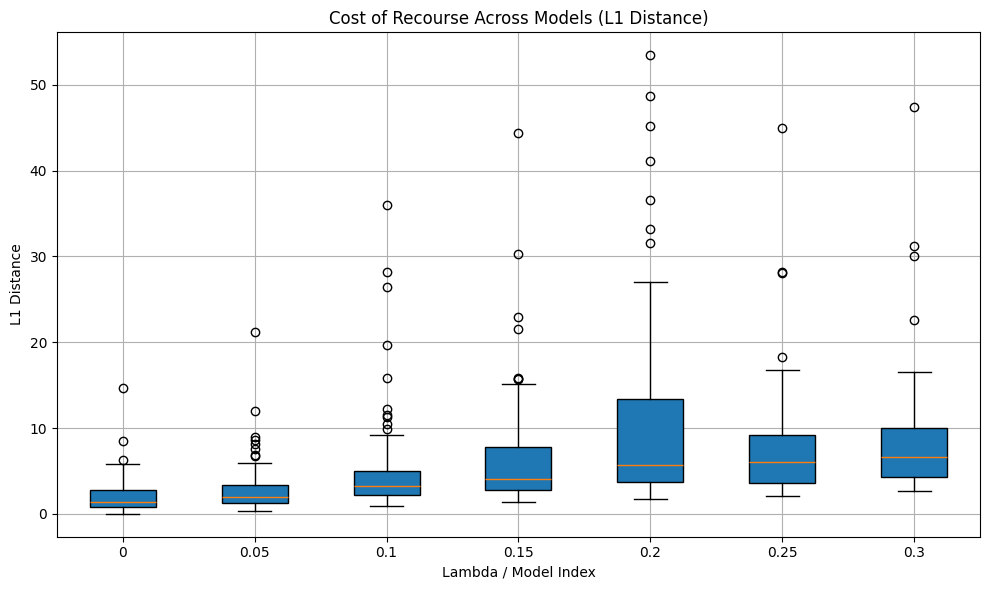

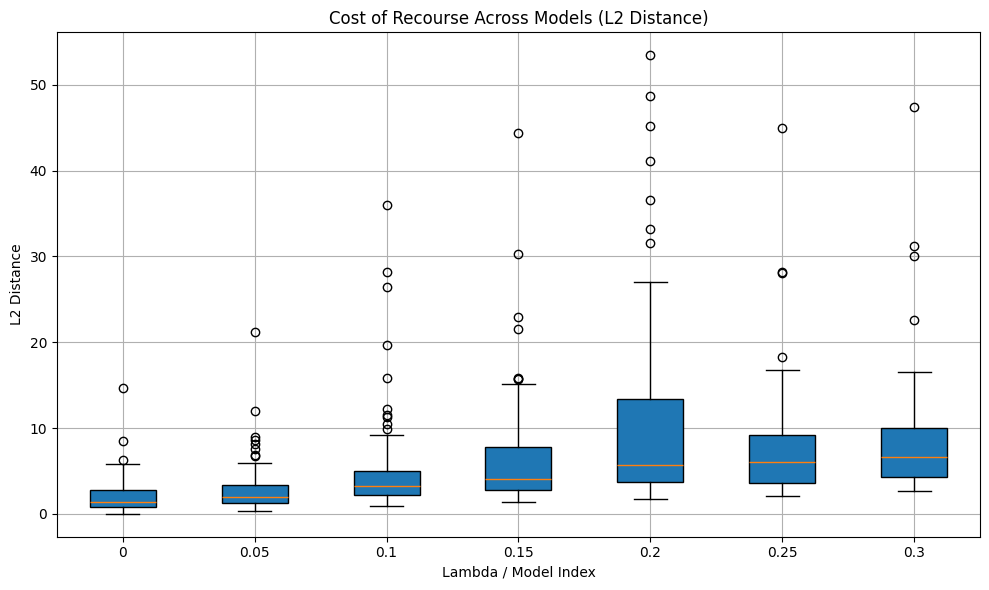

In [21]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l1,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L1 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L1 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.boxplot(cost_of_recourses_l2,patch_artist=True, tick_labels=lambdas)
plt.title("Cost of Recourse Across Models (L2 Distance)")
plt.xlabel("Lambda / Model Index")
plt.ylabel("L2 Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

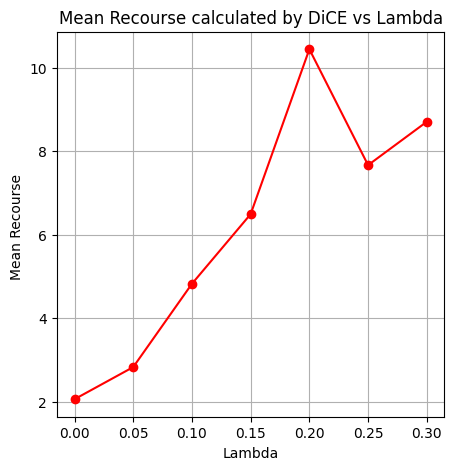

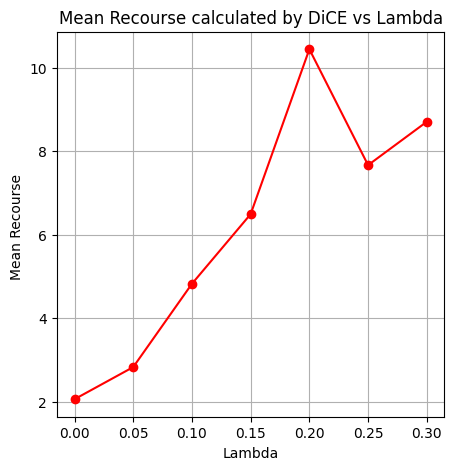

In [22]:
l1_means = [np.mean(sublist) for sublist in cost_of_recourses_l1]
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l1_means, marker='o', color='red')
plt.title("Mean Recourse calculated by CEM vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)


l2_means = [np.mean(sublist) for sublist in cost_of_recourses_l2]
## Plotting of the mean of Recourse genereated by dice After the Training with different Lambdas
plt.figure(figsize=(5, 5))
plt.plot(lambdas, l2_means, marker='o', color='red')
plt.title("Mean Recourse calculated by CEM vs Lambda")
plt.xlabel("Lambda")
plt.ylabel("Mean Recourse ")
plt.grid(True)
